In [1]:
%run startup.py

In [2]:
# plt.style.use('bmh')
plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

In [3]:
import warnings
warnings.filterwarnings('ignore')

### 1. Data preprocessing

In [4]:
# Reading the data
df = pd.read_excel('data/SoyabeanData-Phase2.xlsx')
df['YEAR'] = df['YEAR'].astype(str)
print(df.shape)
df[:3]

(460, 33)


,DISTRICTS,YEAR,YIELD,NDVI_JUN,NDVI_JUL,NDVI_AUG,NDVI_SEP,NDVI_OCT,NDVI_NOV,LAI_JUN,LAI_JUL,LAI_AUG,LAI_SEP,LAI_OCT,LAI_NOV,ET_JUN,ET_JUL,ET_AUG,ET_SEP,ET_OCT,ET_NOV,LST_JUN,LST_JUL,LST_AUG,LST_SEP,LST_OCT,LST_NOV,RF_JUN,RF_JUL,RF_AUG,RF_SEP,RF_OCT,RF_NOV
0,Anuppur,2010,0.40,0.27,0.42,0.55,0.64,0.59,0.50,0.48,0.57,1.18,1.55,1.48,0.96,1.71,14.64,23.41,28.39,21.57,15.75,316.20,308.32,303.46,302.58,303.18,302.78,3.68,13.40,9.78,8.33,1.45,0.18
1,Ashoknagar,2010,1.28,0.20,0.44,0.64,0.50,0.36,0.37,0.27,0.55,1.57,1.68,0.62,0.46,0.60,9.70,20.63,21.71,12.30,10.64,318.60,309.72,301.61,305.58,309.41,305.86,0.80,12.21,8.29,6.26,0.27,0.83
2,Balaghat,2010,1.74,0.47,0.37,0.62,0.76,0.68,0.65,1.01,0.67,1.25,2.36,2.12,1.79,5.37,18.70,27.47,35.17,25.44,19.99,313.59,300.98,300.47,301.02,301.08,300.58,4.44,16.39,16.12,12.96,1.70,0.56


In [5]:
# check for nulls
print(df.isnull().sum().sum())
df.loc[df.isnull().any(axis = 1)]

1


,DISTRICTS,YEAR,YIELD,NDVI_JUN,NDVI_JUL,NDVI_AUG,NDVI_SEP,NDVI_OCT,NDVI_NOV,LAI_JUN,LAI_JUL,LAI_AUG,LAI_SEP,LAI_OCT,LAI_NOV,ET_JUN,ET_JUL,ET_AUG,ET_SEP,ET_OCT,ET_NOV,LST_JUN,LST_JUL,LST_AUG,LST_SEP,LST_OCT,LST_NOV,RF_JUN,RF_JUL,RF_AUG,RF_SEP,RF_OCT,RF_NOV
155,Harda,2013,0.27,0.11,0.11,0.39,0.58,0.49,0.46,0.22,0.13,0.66,1.43,1.16,0.79,1.59,nan,30.49,28.27,17.29,7.49,315.77,300.69,300.56,305.73,307.58,304.33,13.64,22.24,11.26,4.65,2.29,0.00


In [6]:
# let's fill it as previous year value
feat = 'ET_JUL'
f11 = df.YEAR == '2012'
f12 = df.YEAR == '2013'

f2 = df.DISTRICTS == 'Harda'
val = df[f11&f2][feat].values[0]

df.loc[f12&f2,feat] = val

In [7]:
# create fake variables Yield by month (we will set them as constanst)
feat = 'YIELD'
for f in ['JUN','JUL','AUG','SEP','OCT','NOV']:
    df[feat+'_'+f] = df[feat]

In [8]:
# transform data from wide to long format
cols = list(df.columns)
df1 = pd.melt(df, id_vars = cols[:2], value_vars=cols[3:])
df1['DATE'] = df1.YEAR.astype(str) + ' ' + df1.variable.map(lambda x: x.split('_')[1])
df1['DATE'] = pd.to_datetime(df1['DATE'])
df1['DATE_STR'] = df1.DATE.astype(str).str[:7]
df1['MONTH'] = df1.DATE.astype(str).str[5:7]
df1['feat'] = df1.variable.map(lambda x: x.split('_')[0])
del df1['variable']
print(df1.shape)
df1[:3]

(16560, 7)


,DISTRICTS,YEAR,value,DATE,DATE_STR,MONTH,feat
0,Anuppur,2010,0.27,2010-06-01,2010-06,06,NDVI
1,Ashoknagar,2010,0.20,2010-06-01,2010-06,06,NDVI
2,Balaghat,2010,0.47,2010-06-01,2010-06,06,NDVI


In [9]:
# transform the data to wide format with features
df12 = pd.pivot_table(df1, index = 'DATE', columns = ['feat','DISTRICTS'], values = 'value')
print(df12.shape)
df12[:3]

(60, 276)


feat            ET                                                           \
DISTRICTS  Anuppur Ashoknagar Balaghat Barwani Betul Bhind Bhopal Burhanpur   
DATE                                                                          
2010-06-01    1.71       0.60     5.37    3.65  4.37  0.03   1.67      4.04   
2010-07-01   14.64       9.70    18.70   17.64 17.62  2.74  11.37     15.14   
2010-08-01   23.41      20.63    27.47   20.58 24.98 12.69  21.89     23.74   

feat                                                                    \
DISTRICTS  Chhatarpur Chhindwara Damoh Datia Dewas  Dhar Dindori  Guna   
DATE                                                                     
2010-06-01       0.22       4.87  1.19  0.07  2.58  2.44    3.59  0.61   
2010-07-01      10.88      18.22 10.93  4.46 14.11 16.87   15.01  8.77   
2010-08-01      21.41      26.34 22.75 15.95 24.37 20.52   23.61 21.58   

feat                                                                      \
DISTRICTS  Gwalior Harda Hoshangabad Indore Jabalpur Jhabua Katni Mandla   
DATE                                                                       
2010-06-01    0.08  2.89        3.39   2.97     2.13   3.25  0.97   3.72   
2010-07-01    5.11 14.41       15.94  14.87    12.27  18.24  9.13  15.68   
2010-08-01   19.27 23.12       28.61  19.65    21.60  21.97 21.89  26.32   

feat                                                                        \
DISTRICTS  Mandsaur Morena Narsinghpur Neemuch Panna Raisen Rajgarh Ratlam   
DATE                                                                         
2010-06-01     1.23   0.06        3.50    1.10  0.26   2.35    0.94   1.81   
2010-07-01     9.28   3.77       13.73    9.82 10.23  15.43    8.21  15.17   
2010-08-01    20.43  18.31       24.65   21.55 24.57  26.09   21.07  24.28   

feat                                                                         \
DISTRICTS   Rewa Sagar Satna Sehore Seoni Shahdol Shajapur Sheopur Shivpuri   
DATE                                                                          
2010-06-01  0.11  1.55  0.20   2.19  4.21    1.63     1.26    0.11     0.24   
2010-07-01  4.96 11.04  7.28  12.59 18.38   12.09     9.89    7.32     8.77   
2010-08-01 19.04 22.14 20.61  27.08 24.78   23.45    23.55   23.09    22.31   

feat                                                 LAI                      \
DISTRICTS  Sidhi Tikamgarh Ujjain Umaria Vidisha Anuppur Ashoknagar Balaghat   
DATE                                                                           
2010-06-01  0.49      0.22   1.68   1.36    1.07    0.48       0.27     1.01   
2010-07-01  7.69      8.58  13.30  14.12    9.68    0.57       0.55     0.67   
2010-08-01 21.26     19.40  24.49  24.05   23.58    1.18       1.57     1.25   

feat                                                                         \
DISTRICTS  Barwani Betul Bhind Bhopal Burhanpur Chhatarpur Chhindwara Damoh   
DATE                                                                          
2010-06-01    0.25  0.62  0.21   0.28      0.41       0.33       0.65  0.40   
2010-07-01    0.49  0.65  0.34   0.59      0.61       0.68       0.73  0.61   
2010-08-01    0.77  0.99  0.76   1.45      0.86       1.29       1.00  1.19   

feat                                                                       \
DISTRICTS  Datia Dewas Dhar Dindori Guna Gwalior Harda Hoshangabad Indore   
DATE                                                                        
2010-06-01  0.25  0.34 0.21    0.77 0.27    0.28  0.38        0.55   0.29   
2010-07-01  0.42  0.58 0.52    0.78 0.62    0.60  0.46        0.46   0.66   
2010-08-01  1.04  1.22 1.01    1.30 1.59    1.08  1.27        0.99   1.21   

feat                                                                         \
DISTRICTS  Jabalpur Jhabua Katni Mandla Mandsaur Morena Narsinghpur Neemuch   
DATE                                                                          
2010-06-01     0.44   0

In [10]:
# create different variables
list_month = sorted(df1.DATE_STR.unique())

list_year = sorted(df.YEAR.unique())

list_feats = list(df1.feat.unique())

list_regions = sorted(df1.DISTRICTS.unique())

list_colors = ['#008500','#00CC00','#67E667','#1240AB','#6C8CD5','#FF7800']
dict_colors = dict([(k,v) for k,v in zip(list_feats, list_colors)])

### 2. Graphical methods

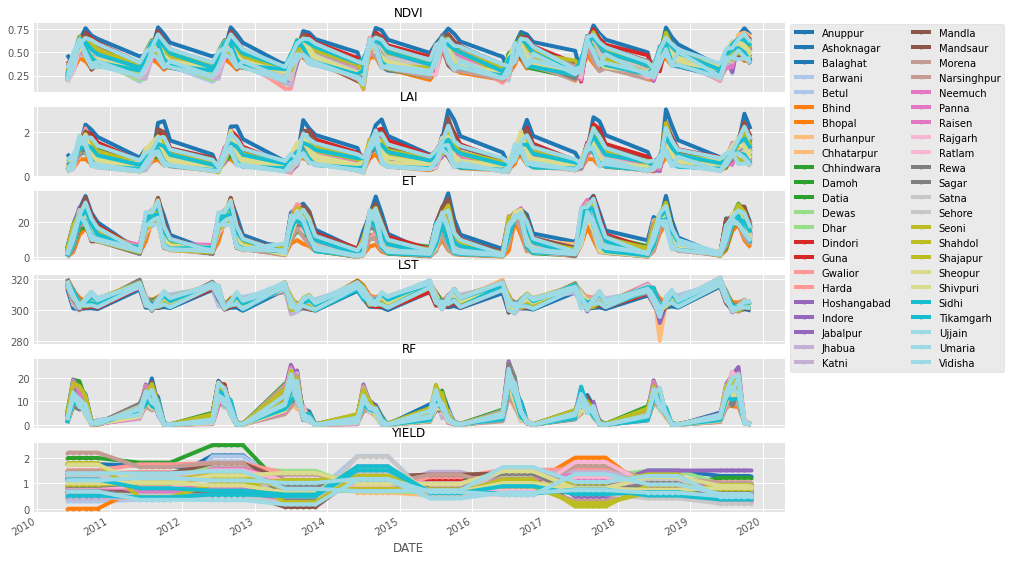

In [11]:
# basic plot
_, ax = plt.subplots(6,1, figsize = (12,10), sharex = True)
for i,feat in enumerate(list_feats):
    _ = df12[feat].iloc[:,:].plot(style = '-' if feat!='YIELD' else '.-', ax = ax[i], cmap = 'tab20', legend = None)
    _ = ax[i].set_title(feat, fontsize = 12)
_ = plt.legend(bbox_to_anchor=(1, 7.05), loc="upper left", ncol = 2)

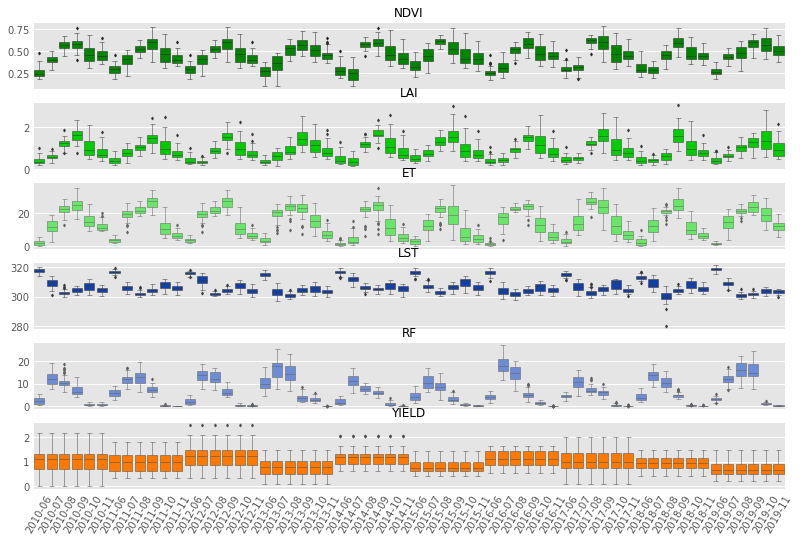

In [12]:
# boxplot
_, ax = plt.subplots(6,1, figsize = (12,8), sharex = True)
for i,feat in enumerate(list_feats):
    filt = df1.feat == feat
    color = list_colors[i]
    p = sns.boxplot(x=df1[filt].DATE_STR, y=df1[filt]['value'], order=list_month, ax = ax[i], linewidth=0.5, saturation=1, fliersize = 2, color=color, palette=None)
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')
    _ = plt.xticks(rotation = 60)

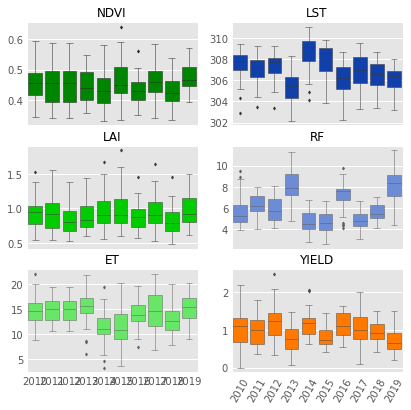

In [13]:
# yearly boxplot
df2 = df1.groupby(['YEAR','DISTRICTS','feat'])['value'].mean().reset_index()

_, ax = plt.subplots(3,2, figsize = (6,6), sharex = True)
for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][:3]):
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].YEAR, y=df2[filt]['value'], order = list_year, ax = ax[i,0], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')
_ = plt.xticks(rotation = 60)
for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][3:]):
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].YEAR, y=df2[filt]['value'], order = list_year, ax = ax[i,1], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i+3])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')
_ = plt.xticks(rotation = 60)

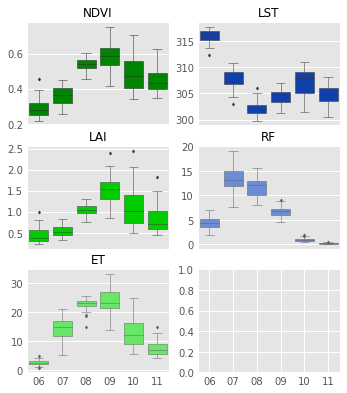

In [14]:
# monthly boxplot
df2 = df1.groupby(['MONTH','DISTRICTS','feat'])['value'].mean().reset_index()
list1 = sorted(df2.MONTH.unique())

_, ax = plt.subplots(3,2, figsize = (5,6), sharex = True)
for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][:3]):
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].MONTH, y=df2[filt]['value'], order = list1, ax = ax[i,0], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')

for i,feat in enumerate(['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD'][3:]):
    if feat == 'YIELD':
        continue
    filt = df2.feat == feat
    p = sns.boxplot(x=df2[filt].MONTH, y=df2[filt]['value'], order = list1, ax = ax[i,1], linewidth=0.5, saturation=1, fliersize = 2, color = list_colors[i+3])
    _ = p.set_title(feat, fontsize = 12)
    _ = p.set_ylabel('')
    _ = p.set_xlabel('')

### 3. Modelling

In [15]:
# functions for time series predictions
# 1) last value method
def ts_predict_last(df, valid_num = 2):    
    vals = df[:-valid_num][-1:].values
    df_out = pd.DataFrame(vals)
    df_out = pd.concat([df_out]*valid_num)
    df_out.columns = list(df.columns)
    df_out.index = df[-valid_num:].index
    return df_out

# 2) moving averages
def ts_predict_moving(df, valid_num = 2, k = 2):
    df1 = df[:-valid_num].copy()
    for i in range(valid_num):
        df2 = df1[-k:].mean()
        df1 = pd.concat([df1, pd.DataFrame(df2).T])
    df1.index = df.index
    return df1[-valid_num:]

# 3) exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
def ts_predict_exponential(df, valid_num = 2, seasonality = 6):    
    def _predict_exponential(x):
        model = ExponentialSmoothing(x[:-valid_num], trend="add", seasonal="add", seasonal_periods=seasonality, damped=True)
        fit1 = model.fit()
        pred1 = fit1.forecast(valid_num)
        return pred1
    df_out = df.apply(_predict_exponential, axis = 0)
    df_out.index = df.index[-valid_num:]
    return df_out
    
# 4) prophet
from prophet import Prophet
def ts_predict_prophet(df, valid_num = 2, seasonality = -1):   
    def _predict_prophet(x):
        # 1) prepare dataframe
        x = x.reset_index()
        x.columns = ['ds','y']
        # 2) build model
        m = Prophet(daily_seasonality=False)
        if seasonality > 0:
            m.add_seasonality(name='monthly', period=seasonality, fourier_order=seasonality)
        m.fit(x[:-valid_num])
        # 3) predict
        df_out = m.predict(x).set_index('ds')['yhat']
        return df_out
    df_out = df.apply(_predict_prophet, axis = 0)
    df_out.index = df.index
    df_out = df_out[-valid_num:]
    return df_out

#### Features prediction

In [16]:
# generate dataset
df11 = pd.pivot_table(df1, index = 'DATE', columns = ['feat','DISTRICTS'], values = 'value')

In [ ]:
# Make predictions
valid_num = 12
seasonality = 6

dict_out = dict()
for feat in list_feats[:-1]:
    df12 = df11[feat]
    dict_out[feat] = list()
    
    # make predictions
    df_pred1 = ts_predict_last(df12, valid_num=valid_num)
    dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())
    
    for k in range(1,7):
        df_pred1 = ts_predict_moving(df12, valid_num=valid_num, k=k)
        dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())
        
    df_pred1 = ts_predict_exponential(df12, valid_num=valid_num, seasonality=seasonality)
    dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())
    
    df_pred1 = ts_predict_prophet(df12, valid_num=valid_num, seasonality=seasonality)
    dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())

In [18]:
pd.options.display.float_format = '{:,.4f}'.format

In [19]:
# output results
pd.DataFrame(dict_out)

,NDVI,LAI,ET,LST,RF
0,0.1080,0.3890,8.9724,4.2495,6.7507
1,0.1080,0.3890,8.9724,4.2495,6.7507
2,0.1080,0.3979,8.1605,4.2229,6.6267
3,0.1101,0.4239,7.3739,4.2224,6.0770
4,0.1153,0.4524,7.4582,4.2784,5.7934
5,0.1117,0.4421,7.3585,4.2786,5.5751
6,0.1025,0.4018,6.7312,4.1222,5.2955
7,0.0582,0.1946,2.8303,1.9956,2.0735
8,0.0656,0.2328,3.7398,3.1651,3.0198


#### Yield prediction

In [20]:
# generate dataset
df12 = pd.pivot_table(df, index = 'YEAR', columns = 'DISTRICTS', values = 'YIELD')

In [ ]:
# Make predictions
valid_num = 2
seasonality = 2

dict_out = dict()
feat = 'YIELD'
dict_out[feat] = list()
    
# make predictions
df_pred1 = ts_predict_last(df12, valid_num=valid_num)
dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())

for k in range(1,7):
    df_pred1 = ts_predict_moving(df12, valid_num=valid_num, k=k)
    dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())

df_pred1 = ts_predict_exponential(df12, valid_num=valid_num, seasonality=seasonality)
dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())

df_pred1 = ts_predict_prophet(df12, valid_num=valid_num, seasonality=seasonality)
dict_out[feat].append((df_pred1 - df12[-valid_num:]).abs().values.mean())

In [22]:
# output results
pd.DataFrame(dict_out)

,YIELD
0,0.4223
1,0.4223
2,0.3476
3,0.3087
4,0.2853
5,0.2891
6,0.2681
7,0.3996
8,0.4312


In [26]:
df1.groupby('feat')['value'].mean().reset_index().T

,0,1,2,3,4,5
feat,ET,LAI,LST,NDVI,RF,YIELD
value,13.9454,0.9119,306.9719,0.4500,6.1028,0.9709
